# 2. Faster RCNN Advanced Tutorial

## Why Mantishrimp

- Mantisshrimp: An object-detection library
- Built on top of different libraries/framework such as Pytorch Lightning and Pytorch
- Features a Unified Data API such: common Parsers (COCO, etc.),
- Customized Parsers (user-defined Parsers)
- Provides flexible model implementations and different backbones
- Helps both researchers and DL engineers in reproducing, replicating published models
- Facilitates applying both existing and new models to either standard datasets as well as custom datasets

- You get the power and flexibility of Pytorch.
- Easily define the backbones and the models.
- Scale up easily with lightning.
- We use plain Pytorch code coupled with mantisshrimp highly flexible and has transparent features
- Less Boilerplate.

## Install
- Simple have Pytorch and get this from GitHub (release on PyPi to be soon)

```
pip install -r requirements.txt
pip install git+git://github.com/lgvaz/mantisshrimp.git
```

In [1]:
!pip install -q 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [2]:
! pip -q install git+git://github.com/lgvaz/mantisshrimp.git


## Imports

Mantisshrimp is built in such a way that is safe to use wildcard imports, .e.g. from mantisshrimp import *.

from mantisshrimp.imports import * will import commonly used packages like np and plt.

from mantisshrimp import * will import all mantis modules needed for development.


In [3]:
from mantisshrimp.imports import *
from mantisshrimp import *
import pandas as pd
import albumentations as A

## Downloading Data
-  The first step is to understand the data. In this task we were given a .csv file with annotations, let's take a look at that.

- Note:

- Replace the input and source with your own path for the dataset directory.
- This notebook was tested with kaggle wheat detection challenge.
- To play with the challenge and this code you can go here https://www.kaggle.com/okeaditya/mantisshrimp-fasterrcnn


## Parser

The first step is to understand the data. In this task we were given a .csv file with annotations, let's take a look at that.


In [4]:
source = Path('../input/global-wheat-detection/')
df = pd.read_csv(source / "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


At first glance, we can make the following assumptions:

-    Multiple rows with the same object_id, width, height
-    A different bbox for each row
-    source doesn't seem relevant right now

- Once we know what our data provides we can create our custom Parser.

- When creating a Parser we inherit from smaller building blocks that provides the functionallity we want:

-    ```DefaultImageInfoParser```: Will parse standard fields for image information, e.g. filepath, height, width
-    ```FasterRCNNParser```: Since we only need to predict bboxes we will use a FasterRCNN model, this will parse all the requirements for using such a model.

We can also specify exactly what fields we would like to parse, in fact, the parsers we are currently using are just helper classes that groups a collection of individual parsers.

We are going to see how to use individual parsers in a future tutorial.




Defining the ```__init__``` is completely up to you, normally we have to pass our data (the df in our case) and the folder where our images are contained (source in our case).

We then override ```__iter__```, telling our parser how to iterate over our data. In our case we call df.itertuples to iterate over all df rows.

```__len__``` is not obligatory but will help visualizing the progress when parsing.

And finally we override all the other methods, they all receive a single argument o, which is the object returned by ```__iter__```.

Now we just need to decide how to split our data and Parser.parse!


In [5]:
class WheatParser(DefaultImageInfoParser, FasterRCNNParser):
    def __init__(self, df, source):
        self.df = df
        self.source = source
        self.imageid_map = IDMap()

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> int:
        return self.imageid_map[o.image_id]

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}.jpg"

    def height(self, o) -> int:
        return o.height

    def width(self, o) -> int:
        return o.width

    def label(self, o) -> List[int]:
        return [1]

    def bbox(self, o) -> List[BBox]:
        return [BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=","))]

## Mantisshrimp now simplifes the boiler plate for you :-)

- It creates a RandomSpitter which divides data into trainand test.
- Then we create the parser and simply parse the data

In [6]:
data_splitter = RandomSplitter([.8, .2])
parser = WheatParser(df, source / "train")
train_rs, valid_rs = parser.parse(data_splitter)

Let's take a look at one record.

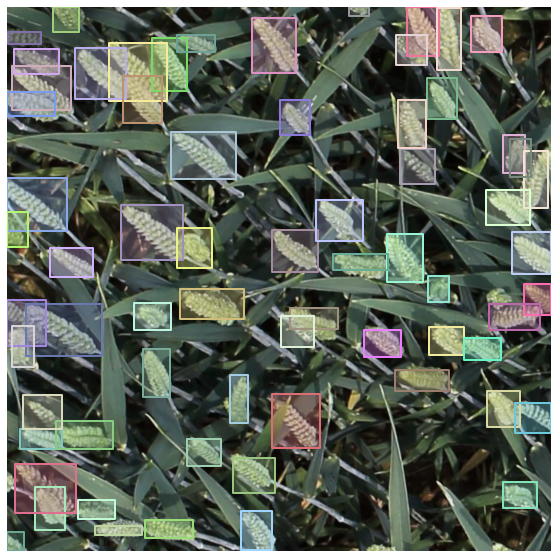

In [7]:
show_record(train_rs[0], label=False)

## Transforms

Mantisshrimp is agnostic to the transform library you want to use. We provide default support for albumentations but if you want to use another library you just need to inherit and override all abstract methods of Transform.

For simplicity, let's use a single transform on the train data and no transforms on the validation data.


In [8]:
train_tfm = AlbuTransform([A.Flip()])

## Datasets


- This is equivalent to PyTorch datasets that we use always.
- For creating a Dataset we just need need to pass the parsed records from the previous step and optionally a transform.

In [9]:
train_ds = Dataset(train_rs, train_tfm)
valid_ds = Dataset(valid_rs)


## Model


- It uses the torchvision implementation of Faster RCNN.
- Best part, we can try Faster RCNN with multiple Backbones as well.

In [10]:
from mantisshrimp.models.mantis_rcnn import *

## Making a Simple Model

- Here we create a simple model for our specific use case, inheriting from MantisFasterRCNN.

- Here pytorch-lightning enters the picture.

- The clas for our model is almost pure lightning, the only big difference is that instead of inheriting from LightningModule we inherit  from the specialized MantisFasterRCNN, this will automatically create the model architecture and load the backbones

- If you are not familiar with lightning, be sure to check their excellent documentation.

In [14]:
class WheatModel(MantisFasterRCNN):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 1e-3, momentum=0.9)
        return opt

- Now we simply create the default Faster RCNN model with resnet50 backbone pretrained on COCO 2017 dataset.

In [ ]:
model = WheatModel(n_class=2, backbone=None)

## Extending Models further.

### Models with FPN

- Feature Pyramid Network (FPN) was an additional made to orginal Faster RCNN paper in 2017.

- For more information please check this orignal paper for Faster RCNN with FPN.

- These lead to improvement in performance in Faster RCNN.

- Mantrisshrimp supports various Resnet styled architectures as backbones for FPN.

- Is supports backbones such as "resnet18", "resnet34","resnet50", "resnet101", "resnet152", "resnext50_32x4d", "resnext101_32x8d", "wide_resnet50_2", "wide_resnet101_2".

- Passing ```pretrained=True``` will create backbone trained on ImageNet weights.

In [11]:
resnet_101_backbone = MantisFasterRCNN.get_backbone_by_name("resnet101", fpn=True, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [12]:
resnet_152_backbone = MantisFasterRCNN.get_backbone_by_name("resnet152", fpn=True, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


### Models without FPN

- The orignal implementation of Faster RCNN as in year 2014 did not have FPN.

- These architectures do not use FPN and they too can have multiple backbones.

- Mantisshrimp supports backbones "resnet18", "resnet34", "resnet50","resnet101", "resnet152", "resnext101_32x8d", "mobilenet", "vgg11", "vgg13", "vgg16", "vgg19", without fpn networks

- Mantrisshrimp thus supports all architectures which can be used with FPN as well as additional CNN models as well.

- For now as an example let us instantiate with mobilenetv2 backbone.

- Passing ```pretrained=True``` will create backbone trained on ImageNet weights.

In [13]:
mobibenet_v2_backbone = MantisFasterRCNN.get_backbone_by_name("mobilenet", fpn=False, pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


- You can pass all the arguments that you could for torchvision Faster RCNN, E.g. Anchor boxes, iou_threshold, etc.
- Have a look at those arguments in torchvision.

### Making the advanced model

- We use the same WheatModel which inherited from ```MantisFasterRCNN```.

In [ ]:
class WheatModel(MantisFasterRCNN):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 1e-3, momentum=0.9)
        return opt

In [15]:
model = WheatModel(n_class=2, backbone=resnet_101_backbone)

- It bacame so simple to create the model with resnet 101 backbone and fpn isn't it?
- You don't have to worry how backbones should be connected with Faster RCNN, Mantisshrimp integrates them.
- Just inherit from the class, and add your optimizers as you would do in pytorch_lightning

## Making a more customized model

- Note while using these customization make sure you understand them. It will give errors while training.
- So, make sure your parameters work as per data and model.
- You can pass the same arguments for torchvision FasterRCNN as well.
- These torchvision parameters work for both models with FPN and without FPN networks.

Here is what all can be customized. Parameters that are set to None, take defualt values as in torchvision.

```
num_classes=None,
# transform parameters
min_size=800, max_size=1333,
image_mean=None, image_std=None,

# RPN parameters
rpn_anchor_generator=None, rpn_head=None, rpn_pre_nms_top_n_train=2000, 
rpn_pre_nms_top_n_test=1000, rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000, 
rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,


# Box parameters
box_roi_pool=None, box_head=None, box_predictor=None, box_score_thresh=0.05, 
box_nms_thresh=0.5, box_detections_per_img=100,
box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5, box_batch_size_per_image=512, 
box_positive_fraction=0.25, bbox_reg_weights=None
```

- Do check these in torchvision https://pytorch.org/docs/stable/_modules/torchvision/models/detection/faster_rcnn.html

Lets say you need modify AnchorGenerator.

(I am modifying it to default value, which would be set if it would be None here. You can experiment with it)

In [ ]:
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
ft_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

- And if we need a Region of Interest Pooler.

In [ ]:
ft_roi_pooler = torchvision.ops.MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

Also if you need image mean and std specific for your data.

In [ ]:
# Imagenet mean and std it will taken automatically if not explicity given
ft_mean = [0.485, 0.456, 0.406] # ImageNet mean
ft_std = [0.229, 0.224, 0.225] # ImageNet std

Just pass them while you instantiate the Model

In [ ]:
model = WheatModel(n_class=2, backbone=resnet_101_backbone, image_mean=ft_mean, image_std=ft_std, rpn_anchor_generator=ft_anchor_generator, box_roi_pool=ft_roi_pooler)

 ## DataLoader

Another difference from lightning is that all mantis models have a `dataloader` method that returns a customized `DataLoader` for each model.

- This dataloader is just usual torch dataloader.

In [16]:
train_dl = model.dataloader(train_ds, shuffle=True, batch_size=8, num_workers=2)
valid_dl = model.dataloader(valid_ds, batch_size=8, num_workers=2)

## Train

- Again leverage the power of Pytorch Lightning.
- Train for multiple GPUs, withe the same trainer function that of lightning.
- You can pass same arguments that you would give for normal Trainer module.

In [1]:
trainer = Trainer(max_epochs=2, gpus=1)

In [ ]:
trainer.fit(model, train_dl, valid_dl)

## Saving model

In [28]:
# Save the model as same as you would do for a Pytorch model
# You can also use lightning features to even automate this.

torch.save(model.state_dict(), "mantiss_faster_rcnn.pt")

## Inference

Prediction is a straightforward process. 

You can make either a single item prediction or a batch prediction. Feed the model and you will get the corresponding boxes and labels.

You can also create a test_loader and achieve the same.

Here I'm reading the images one by one and using torch.

Mantisshrimp is very flexible with torch. As models trained are pytorch models itself.

In [29]:
detection_threshold = 0.45

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')

    return " ".join(pred_strings)

In [33]:
detection_threshold = 1e-8
results = []
model.eval()
model.to(device)
for images in os.listdir("../input/global-wheat-detection/test/"):
    image_path = os.path.join("../input/global-wheat-detection/test/", images)
    image = cv2.imread(image_path)
    image = np.transpose(image, (2, 0, 1))
    image = image / 255.
    image = torch.tensor(image, dtype=torch.float)
    image = torch.unsqueeze(image, 0)
    image = image.to(device)

#     print(image.shape)
    with torch.no_grad():
        outputs = model(image)
    
#     print(outputs)

    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    image_id = images[:-3]

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)
#     break


In [34]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,348a992bb.,0.9866 141 40 113 82 0.9862 282 336 81 89 0.97...
1,796707dd7.,0.9791 898 337 104 82 0.9735 502 789 96 92 0.9...
2,aac893a91.,0.9824 613 917 81 96 0.9774 454 857 92 91 0.97...
3,f5a1f0358.,0.9756 689 206 122 85 0.9733 817 406 93 85 0.9...
4,cb8d261a3.,0.9807 263 772 112 74 0.9795 649 678 93 70 0.9...


You see how simple and easy it becomes to experiment with mantisshrimp

Simplifying your data preprocessing and model defintion, while maintaining faithful integrity with Pytorch.

Pytorch Lightning allows us to again simplify the boiler plate needed, also allowing to quickly scale up our code.

Do check our [docs](https://lgvaz.github.io/mantisshrimp/index.html) and [tutorials](https://lgvaz.github.io/mantisshrimp/tutorials/hub_detr_finetune_pennfundan.html) to learn more.